## Imports

In [26]:
pip install pyccel

In [27]:
import numpy as np
import sympy as sp
from sympy.utilities.lambdify import lambdify

from sympy import init_printing
init_printing(use_latex=True)
import matplotlib.pyplot as plt

from numba import njit
import time
from pyccel.epyccel import epyccel
from pyccel.decorators import types

## Pure python function

In [28]:
def solve_1d_burger_pure(u, un, nt, nx, dt, dx, nu):
    for n in range(nt):  
        for i in range(nx): un[i] = u[i]
        for i in range(1, nx-1): 
            u[i] = un[i] - un[i] * dt / dx * (un[i] - un[i-1]) + nu * dt / dx**2 * (un[i+1] - 2 * un[i] + un[i-1])
        u[0] = un[0] - un[0] * dt / dx * (un[0] - un[-2]) + nu * dt / dx**2 * (un[1] - 2 * un[0] + un[-2])
        u[-1] = u[0]
    return 0

## Numba accelerator

In [29]:
@njit(fastmath=True)
def solve_1d_burger_numba(u, un, nt, nx, dt, dx, nu):
    for n in range(nt):  
        for i in range(nx): un[i] = u[i]
        for i in range(1, nx-1): 
            u[i] = un[i] - un[i] * dt / dx * (un[i] - un[i-1]) + nu * dt / dx**2 * (un[i+1] - 2 * un[i] + un[i-1])
        u[0] = un[0] - un[0] * dt / dx * (un[0] + un[-2]) + nu * dt / dx**2 * (un[1] - 2 * un[0] + un[-2])
        u[-1] = u[0]
    return 0

## Pyccel accelerator

In [30]:
#add the pyccel decorator to accelerate code
def solve_1d_burger_pyccel(u:'float[:]', un:'float[:]', nt:'int', nx:'int', dt:'float', dx:'float', nu:'float'):
    for n in range(nt):  
        for i in range(nx): un[i] = u[i]
        for i in range(1, nx-1): 
            u[i] = un[i] - un[i] * dt / dx * (un[i] - un[i-1]) + nu * dt / dx**2 * (un[i+1] - 2 * un[i] + un[i-1])
        u[0] = un[0] - un[0] * dt / dx * (un[0] + un[-2]) + nu * dt / dx**2 * (un[1] - 2 * un[0] + un[-2])
        u[-1] = u[0]
        
    return 0

## Inputs

In [31]:
#sympy computation
x, nu, t = sp.symbols('x nu t')
phi = (sp.exp(-(x - 4 * t)**2 / (4 * nu * (t + 1))) +
       sp.exp(-(x - 4 * t - 2 * sp.pi)**2 / (4 * nu * (t + 1))))

phiprime = phi.diff(x)
u = -2 * nu * (phiprime / phi) + 4
ufunc = lambdify((t, x, nu), u)

In [32]:
###variable declarations
nx = 201
nt = 100
dx = 2 * np.pi / (nx - 1)
nu = .07
dt = dx * nu

x = np.linspace(0, 2 * np.pi, nx)
un = np.empty(nx)
t = 0

## Plot initial condition

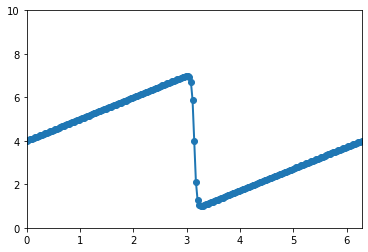

In [33]:
u = np.asarray([ufunc(t, x0, nu) for x0 in x])
plt.figure()
plt.plot(x, u, marker='o', lw=2)
plt.xlim([0, 2 * np.pi])
plt.ylim([0, 10]);

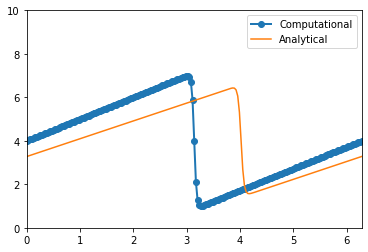

In [34]:
solve_1d_burger_pure(u, un, nt, nx, dt, dx, nu)

# Analytical solution
u_analytical = np.asarray([ufunc(nt * dt, xi, nu) for xi in x])


u = np.asarray([ufunc(t, x0, nu) for x0 in x])
plt.figure()
plt.plot(x, u, marker='o', lw=2, label='Computational')
# plt.xlim([0, 2 * np.pi])
# plt.ylim([0, 10]);

#Plotting data
# plt.figure()
# plt.plot(x,u, marker='o', lw=2, label='Computational')
plt.plot(x, u_analytical, label='Analytical')
plt.xlim([0, 2 * np.pi])
plt.ylim([0, 10])
plt.legend();

## Call Funtions

### Pure function

In [35]:
%timeit solve_1d_burger_pure(u, un, nt, nx, dt, dx, nu)

10 loops, best of 5: 39.1 ms per loop


### Function with numba accelerator

In [36]:
%timeit solve_1d_burger_numba(u, un, nt, nx, dt, dx, nu)

The slowest run took 28725.60 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 14.8 µs per loop


### Function with pyccel accelerator

In [37]:
solve_1d_burger_f90 = epyccel(solve_1d_burger_pyccel)
%timeit solve_1d_burger_f90(u, un, nt, nx, dt, dx, nu)

10000 loops, best of 5: 81.7 µs per loop
